1D Heat Transfer Analysis
Governing equation for steady state: $$\nabla(\vec{k}\nabla\theta) = -q^B$$
where $\theta$ is the temperature and $q$ is the heat.
In 1D, this is $$\theta '' = \frac{-q^B}{k}$$
The weak from of the heat equation is then: $$(\theta ',\phi ') = (\frac{-q^B}{k},\phi)$$
where $(\cdot,\cdot)$ denotes scalor product and $\phi$ is any function in $V$ which is a vector space containing all function who satisfy the boundary conditions and whose first derivative is piece-wise contenious.
Now consider $v_h$ in place of $\phi$, where $v_h$ exisits in $V_h$ which is finite dimentional (unlike $V$).
Now let us create $n$ "elements", and basis functions corresponding to the elements. For simplisity, we consider only linear functions $\phi$ with the following condition:
\begin{equation}
  \phi_i(x_j) =
    \begin{cases}
      1 & \text{if $i=j$}\\
      0 & \text{if $i\neq j$}\\
    \end{cases}       
\end{equation}
That is, $$v_h = \sum\limits_{i=0}^{n}v_i\phi_i$$
Now, we re-write our 1D heat equation in weak form: $$\sum\limits_{i=0}^{n}u_i(\phi_i',\phi_j')=(\frac{-q^B}{k},\phi_j)$$
That is: $$AU=F$$
where $A_{ij}=(\phi_i',\phi_j')$, $U^T={u_1, u_2, u_3, ... u_n}$, and $F^T_i = (-q^B/k, \phi_i)$
We want to solve for $U$.


In [20]:
import numpy as np
import math
import sympy as sym
import math

In [44]:
#setting the variables/functions
n_element = 10
dx = 1/n_element
#the base functions are cones with magnitude 1 at each node.
def get_base(ith_node, dx):
    x = sym.Symbol( 'x', real=True )
    formula = sym.Piecewise((x/dx+(1-ith_node), sym.Interval(dx*ith_node-dx, dx*ith_node).contains(x)), (-x/dx+(1+ith_node), sym.Interval(dx*ith_node, dx*ith_node+dx).contains(x)), (0,True))
    return formula
#matrix elements for A
def get_a(row, column):
    x = sym.Symbol('x', real = True)
    row_base = get_base(row, dx)
    column_base = get_base(column, dx)
    diff_row_base = sym.diff(row_base, x)
    diff_column_base = sym.diff(column_base, x)
    return sym.integrate(diff_row_base*diff_column_base, (x, 0, 1))
#matrix elements for F
def get_f(row):
    x = sym.Symbol('x', real = True)
    k = 1
    q = 1
    f = -q/k
    row_base = get_base(row, dx)
    return -sym.integrate(f*row_base, (x, 0, 1))

In [25]:
'''#this one takes a while to run (>1min)
#Assembling matrix A
#no row or column corresponding to the 0th and nth node (due to boundary condition, u_0 and u_n is preset.)
A = np.zeros((n_element+1, n_element+1))
for ith_row in range(1, n_element):
    A.itemset((ith_row, ith_row-1), get_a(ith_row, ith_row-1))
    A.itemset((ith_row, ith_row), get_a(ith_row, ith_row))
    A.itemset((ith_row, ith_row+1), get_a(ith_row, ith_row+1))

A.itemset((0,0), get_a(0,0))
A.itemset((0,1), get_a(0,1))
A.itemset((n_element, n_element), get_a(n_element, n_element))
A.itemset((n_element, n_element-1), get_a(n_element, n_element-1))

print(A)'''


[[ 10. -10.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-10.  20. -10.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. -10.  20. -10.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. -10.  20. -10.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. -10.  20. -10.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. -10.  20. -10.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. -10.  20. -10.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. -10.  20. -10.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. -10.  20. -10.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. -10.  20. -10.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. -10.  10.]]


In [12]:
'''#Assumblying vector F
F = np.zeros(n_element+1)
for ith_element in range(1, n_element+1):
    F.itemset(ith_element, get_f(ith_element))
'''

In [31]:
#Assembling matrix A
#no row or column corresponding to the 0th and nth node (due to boundary condition, u_0 and u_n is preset.)
A = np.zeros((n_element-1, n_element-1))
for ith_row in range(2, n_element-1):
    A.itemset((ith_row-1, ith_row-2), get_a(ith_row, ith_row-1))
    A.itemset((ith_row-1, ith_row-1), get_a(ith_row, ith_row))
    A.itemset((ith_row-1, ith_row), get_a(ith_row, ith_row+1))

A.itemset((0,0), get_a(1,1))
A.itemset((0,1), get_a(1,2))
A.itemset((n_element-2, n_element-2), get_a(n_element-1, n_element-1))
A.itemset((n_element-2, n_element-3), get_a(n_element-1, n_element-2))

print(A)

[[ 20. -10.   0.   0.   0.   0.   0.   0.   0.]
 [-10.  20. -10.   0.   0.   0.   0.   0.   0.]
 [  0. -10.  20. -10.   0.   0.   0.   0.   0.]
 [  0.   0. -10.  20. -10.   0.   0.   0.   0.]
 [  0.   0.   0. -10.  20. -10.   0.   0.   0.]
 [  0.   0.   0.   0. -10.  20. -10.   0.   0.]
 [  0.   0.   0.   0.   0. -10.  20. -10.   0.]
 [  0.   0.   0.   0.   0.   0. -10.  20. -10.]
 [  0.   0.   0.   0.   0.   0.   0. -10.  20.]]


In [48]:
#initial conditions

u0=0.1
un=0

#Assumblying vector F
#0th and nth node omitted, 1st and n-1th node contains boundary conditions
F = np.zeros(n_element-1)
for ith_element in range(2, n_element-1):
    F.itemset(ith_element-1, get_f(ith_element))
F.itemset(0, (get_f(1)-u0*get_a(1, 0)))
F.itemset(n_element-2, (get_f(n_element-1)-un*get_a(n_element-1, n_element)))

print(F)

[1.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [49]:
#obtaining U, adding u0 and un
U = np.dot(np.linalg.inv(A), F)
U = np.append(u0, U)
U = np.append(U, un)
print(U)

[0.1   0.135 0.16  0.175 0.18  0.175 0.16  0.135 0.1   0.055 0.   ]


<function matplotlib.pyplot.show(close=None, block=None)>

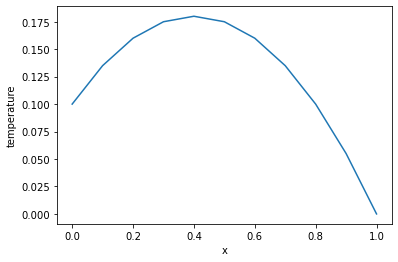

In [52]:
import matplotlib.pyplot as plt
x = np.linspace(0, 1, n_element+1)
plt.plot(x, U)
plt.xlabel('x')
plt.ylabel('temperature')
plt.show